# Example: Compare ASCAT SM against ISMN

In [1]:
# install the ISMN package first https://github.com/TUW-GEO/ismn
import ismn.interface as ismn 
import warnings

# install the ascat package first https://github.com/TUW-GEO/ascat
from ascat.read_native.cdr import AscatGriddedNcTs

import pytesmo.temporal_matching as temp_match
import pytesmo.scaling as scaling
import pytesmo.metrics as metrics
from pytesmo.utils import rootdir

import pandas as pd
import matplotlib.pyplot as plt
import tempfile

%matplotlib inline

Create the ascat reader:

In [2]:
testdata_path = rootdir() / "tests" / "test-data"
ascat_data_folder = testdata_path / "sat" / "ascat" / "netcdf" / "55R22"
ascat_grid_fname = testdata_path / "sat" / "ascat" / "netcdf" / "grid" / "TUW_WARP5_grid_info_2_1.nc"
static_layer_path = testdata_path / "sat" / "h_saf" / "static_layer"


#init the AscatSsmCdr reader with the paths
with warnings.catch_warnings():
    warnings.filterwarnings('ignore') # some warnings are expected and ignored
    
    ascat_reader = AscatGriddedNcTs(
        ascat_data_folder,
        "TUW_METOP_ASCAT_WARP55R22_{:04d}",
        grid_filename=ascat_grid_fname,
        static_layer_path=static_layer_path
    )

Create the ismn reader:

In [3]:
#set path to ISMN data
path_to_ismn_data = testdata_path / "ismn" / "multinetwork" / "header_values"

#Initialize reader
meta_path = tempfile.mkdtemp()
ISMN_reader = ismn.ISMN_Interface(path_to_ismn_data, meta_path=meta_path)
list(ISMN_reader.stations_that_measure('soil_moisture'))

Processing metadata for all ismn stations into folder /home/samuel/projects/QA4SM/pytesmo/tests/test-data/ismn/multinetwork/header_values.
This may take a few minutes, but is only done once...
Hint: Use `parallel=True` to speed up metadata generation for large datasets


Files Processed: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:00<00:00, 191.64it/s]

Metadata generation finished after 0 Seconds.
Metadata and Log stored in /tmp/tmpuaouwbc9
Found existing ismn metadata in /tmp/tmpuaouwbc9/header_values.csv.


[Sensors at 'CST_01': ['ECH20-EC-TM_soil_moisture_0.050000_0.050000'],
 Sensors at 'CST_02': ['ECH20-EC-TM_soil_moisture_0.050000_0.050000'],
 Sensors at 'AAMU-jtg': ['Hydraprobe-Analog-(2.5-Volt)_soil_moisture_0.050000_0.050000'],
 Sensors at 'Abrams': ['Hydraprobe-Analog-(2.5-Volt)_soil_moisture_0.050000_0.050000'],
 Sensors at 'Adams_Ranch_#1': ['Hydraprobe-Analog-(2.5-Volt)_soil_moisture_0.050000_0.050000'],
 Sensors at 'node414': ['EC5_soil_moisture_0.050000_0.050000'],
 Sensors at 'node505': ['EC5_soil_moisture_0.050000_0.050000'],
 Sensors at 'node703': ['EC5_soil_moisture_0.050000_0.050000']]

We will compare only the first station to ASCAT here. For this station, we will compare ASCAT to the available measured time series from depths above 10 cm (which is only one in this case).

In [4]:
station = next(ISMN_reader.stations_that_measure('soil_moisture'))

We will first temporally collocate the ISMN time series to ASCAT. Then we will perform a CDF matching so that biases between the two will be removed.

In [5]:
label_ascat='sm'
label_insitu='insitu_sm'

ISMN_time_series = station[0].read_data()
ascat_time_series = ascat_reader.read(station.lon,
                                      station.lat,
                                      mask_ssf=True,
                                      mask_frozen_prob = 5,
                                      mask_snow_prob = 5).tz_localize("UTC")

In [6]:
ascat_time_series

,ssf,proc_flag,orbit_dir,sm,sm_noise,snow_prob,frozen_prob,abs_sm_gldas,abs_sm_noise_gldas,abs_sm_hwsd,abs_sm_noise_hwsd
2007-05-22 02:41:57.999995+00:00,1,0,b'D',62.0,3.0,0,4,NaN,NaN,NaN,NaN
2007-05-22 14:00:06.000021+00:00,1,0,b'A',87.0,4.0,0,4,NaN,NaN,NaN,NaN
2007-05-24 03:40:32.000005+00:00,1,0,b'D',70.0,3.0,0,4,NaN,NaN,NaN,NaN
2007-05-25 14:37:59.999998+00:00,1,0,b'A',87.0,4.0,0,4,NaN,NaN,NaN,NaN
2007-05-27 02:38:29.999996+00:00,1,0,b'D',71.0,3.0,0,4,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...
2014-06-25 13:51:37.000006+00:00,1,0,b'A',83.0,4.0,0,0,NaN,NaN,NaN,NaN
2014-06-27 03:32:04.999979+00:00,1,0,b'D',79.0,4.0,0,0,NaN,NaN,NaN,NaN
2014-06-27 14:50:18.000019+00:00,1,0,b'A',81.0,4.0,0,0,NaN,NaN,NaN,NaN
2014-06-30 02:30:05+00:00,1,0,b'D',77.0,4.0,0,0,NaN,NaN,NaN,NaN


In [7]:
ISMN_time_series

,soil_moisture,soil_moisture_flag,soil_moisture_orig_flag
date_time,,,
2008-07-01 00:00:00,0.50,C03,M
2008-07-01 01:00:00,0.50,C03,M
2008-07-01 02:00:00,0.50,C03,M
2008-07-01 03:00:00,0.50,C03,M
2008-07-01 04:00:00,0.50,C03,M
...,...,...,...
2010-07-31 19:00:00,0.26,U,M
2010-07-31 20:00:00,0.26,U,M
2010-07-31 21:00:00,0.26,U,M


We will rename the soil_moisture column from ISMN so it's easier to differentiate them in plots. Also, drop all the NaNs here, they might lead to problems further on.

In [8]:
ismn_sm = ISMN_time_series[["soil_moisture"]].dropna()
ismn_sm.rename(columns={'soil_moisture':label_insitu}, inplace=True)
ascat_sm = ascat_time_series[["sm"]].dropna()

Now we need to temporally collocate the two time series. We do this using the nearest neighbour within +- 1 hour.

In [9]:
matched_ismn = temp_match.temporal_collocation(ascat_sm, ismn_sm, pd.Timedelta(1, "H"))
matched_data = pd.concat((ascat_sm, matched_ismn), axis=1).dropna()
matched_data

/home/samuel/projects/QA4SM/pytesmo/src/pytesmo/temporal_matching.py:299: UserWarning: No timezone given for other, assuming it's in the same timezone as reference, UTC.
  warnings.warn(


,sm,insitu_sm
2008-07-01 02:41:05+00:00,79.0,0.50
2008-07-01 13:59:12.999987+00:00,81.0,0.49
2008-07-02 13:38:37.000012+00:00,60.0,0.47
2008-07-03 03:39:39.000011+00:00,68.0,0.46
2008-07-04 14:37:08.999993+00:00,66.0,0.45
...,...,...
2010-07-25 13:57:54.000013+00:00,78.0,0.41
2010-07-27 03:38:19.999997+00:00,76.0,0.38
2010-07-28 14:35:46.999995+00:00,67.0,0.35
2010-07-30 02:36:15.000004+00:00,66.0,0.31


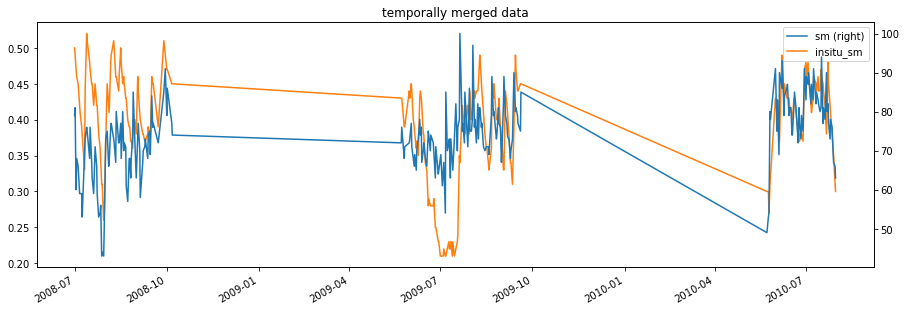

In [10]:
fig1, ax1 = plt.subplots()
matched_data.plot(figsize=(15,5),secondary_y=[label_ascat],
                  title='temporally merged data', ax=ax1);

There is still a bias between the time series, especially at the start. We can remove it by scaling, here we use CDF matching as a nonlinear scaling method.

/home/samuel/projects/QA4SM/pytesmo/src/pytesmo/cdf_matching.py:174: UserWarning: The bins have been resized
  warnings.warn("The bins have been resized")


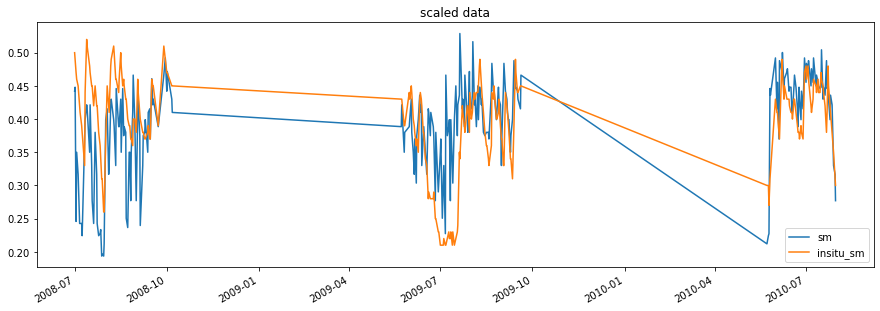

In [11]:
# this takes the matched_data DataFrame and scales all columns to the
# column with the given reference_index, in this case in situ
scaled_data = scaling.scale(matched_data, method='cdf_match',
                            reference_index=1)

# now the scaled ascat data and insitu_sm are in the same space
fig2, ax2 = plt.subplots()
scaled_data.plot(figsize=(15,5), title='scaled data', ax=ax2);

To see the correlation, we can create a scatterplot.

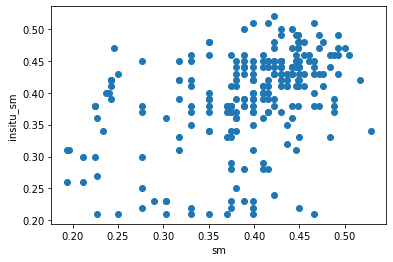

In [12]:
fig3, ax3 = plt.subplots()
ax3.scatter(scaled_data[label_ascat].values, scaled_data[label_insitu].values)
ax3.set_xlabel(label_ascat)
ax3.set_ylabel(label_insitu);

We can also calculate the correlation and other interesting metrics:

In [13]:
# calculate correlation coefficients, RMSD, bias, Nash Sutcliffe
x, y = scaled_data[label_ascat].values, scaled_data[label_insitu].values

from scipy import stats
print("Pearson's R    = {:.2f}, p = {:.2e}".format(*stats.pearsonr(x, y)))
print("Spearman's rho = {:.2f}, p = {:.2e}".format(*stats.spearmanr(x, y)))
print("Kendall's tau  = {:.2f}, p = {:.2e}".format(*stats.kendalltau(x, y)))
print()
print("RMSD = {:.2f}".format(metrics.rmsd(x, y)))
print("Bias = {:.2f}".format(metrics.bias(x, y)))
print("Nash Sutcliffe = {:.2f}".format(metrics.nash_sutcliffe(x, y)))

Pearson's R    = 0.41, p = 1.77e-11
Spearman's rho = 0.46, p = 5.86e-14
Kendall's tau  = 0.33, p = 2.92e-13

RMSD = 0.08
Bias = -0.00
Nash Sutcliffe = -0.22


The correlations are all significant, although there are only in the medium range. The bias is zero, because we scaled the data and thereby removed the bias.